# Analiza danych spektroskopii MRI guzów mózgu

## 1. Data Understanding

### 1.1 Importowanie bibliotek

In [0]:
!pip install shap

     |████████████████████████████████| 266kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.31.0-cp36-cp36m-linux_x86_64.whl size=375014 sha256=16437f561bcb8d92d306efa3f6c05dba5113838ee03a15940acb475b8ebf7cdc
  Stored in directory: /root/.cache/pip/wheels/7b/2d/46/ff8959add2e4e99a18a6e90b82f47508bf52fdf7e7d806f7df
Successfully built shap


In [0]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale, MultiLabelBinarizer
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import shap

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'whitegrid' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6


### 1.2 Funkcje pomocnicze

In [0]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = MultiLabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot, var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target  )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='blue', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
  

### 1.3 Załadowanie danych

In [0]:
from google.colab import files
uploaded = files.upload()

Saving vector_all_bezZerowych1.csv to vector_all_bezZerowych1.csv


In [0]:
import io
patients = pd.read_csv(io.BytesIO(uploaded['vector_all_bezZerowych1.csv']))
patients = patients.iloc[:,1:]
print ('Datasets:', patients.shape)

Datasets: (30, 17)


### 1.4 Podsumowania statystyczne i wizualizacje

#### 1.4.1 Rozmiar dataset'u i kompletność

In [0]:
patients.head()

,Gln_30,Ins_30,MM09_30,MM12_30,MM20_30,NAA_30,TNAA_30,TCho_30,TCr_30,Glx_30,TLM09_30,TLM13_30,TLM20_30,Glth_135,TCho_135,Glx_135,GROUP
0,6.962389,6.603120,3.325362,0.566879,18.68911,8.198750,12.736640,4.259732,13.62241,21.91664,4.479752,1.259245,18.68911,1.316439,3.379975,2.564972,1
1,19.245340,6.896875,9.765652,4.724729,17.30352,4.549144,7.094076,8.884609,17.63714,23.80527,15.700670,36.031030,21.86944,0.410006,7.591995,4.129187,1
2,198.937900,322.238500,106.423000,25.270130,420.94210,177.447900,230.258100,115.502400,223.56760,552.76060,125.445000,80.061020,420.94210,8.872886,104.716900,43.185720,1
3,857.858600,44.424700,456.531400,149.948600,644.66830,102.247400,199.813700,315.170500,416.05130,1115.79800,649.700700,998.875100,714.84570,48.430580,231.068300,406.473300,1
4,127.052200,80.768920,85.408050,22.708230,301.42650,95.390890,220.322400,100.869000,277.29750,496.18610,133.262300,283.990300,301.42650,50.368930,64.408940,173.578800,1


In [0]:
print('Training Set Dataframe Shape: ', patients.shape)
print('\nTotal number of entries in our dataset: ', patients.shape[0])

print('\nNumber of missing entries in total dataset:')
print(patients.isnull().sum())

Training Set Dataframe Shape:  (30, 17)

Total number of entries in our dataset:  30

Number of missing entries in total dataset:
Gln_30      0
Ins_30      0
MM09_30     0
MM12_30     0
MM20_30     0
NAA_30      0
TNAA_30     0
TCho_30     0
TCr_30      0
Glx_30      0
TLM09_30    0
TLM13_30    0
TLM20_30    0
Glth_135    0
TCho_135    0
Glx_135     0
GROUP       0
dtype: int64


#### 1.4.2 Macierz korelacji poszczególnych metabolitów ze sobą

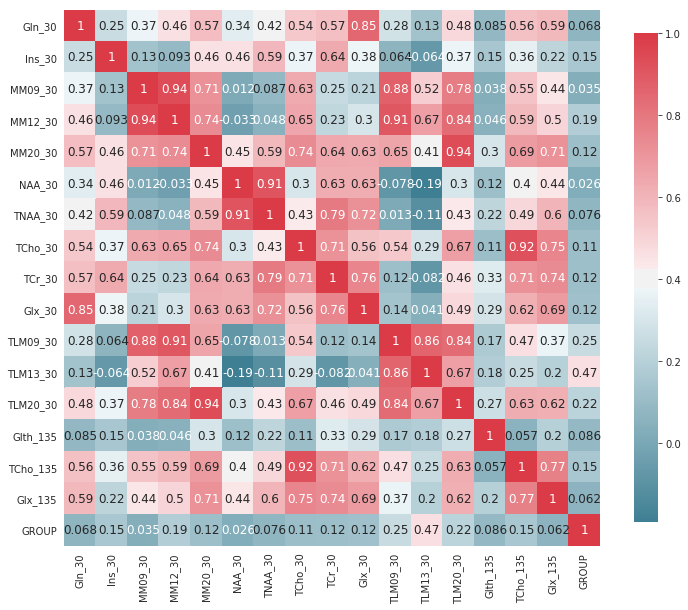

In [0]:
plot_correlation_map(patients)

#### 1.4.3 Przegląd poszczególnych metabolitów względem grupy złośliwości guza

##### Gln_30

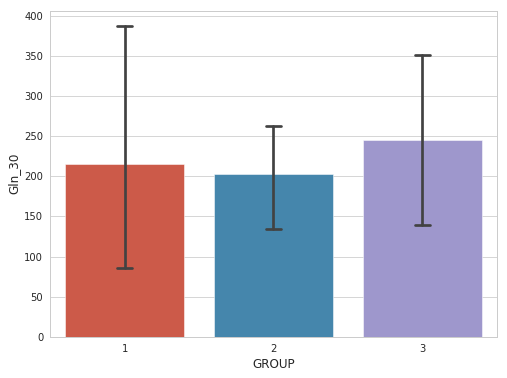

In [0]:
ax = sns.barplot(x='GROUP', y='Gln_30', data=patients, capsize=.1)

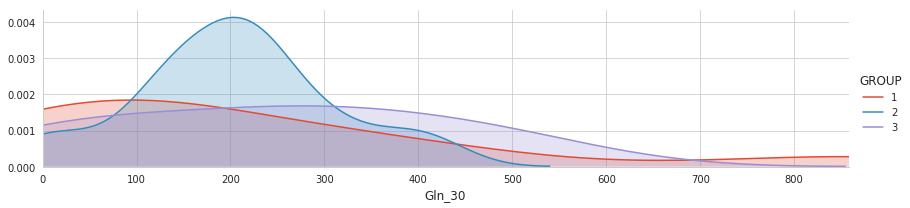

In [0]:
plot_distribution( patients , var = 'Gln_30' , target = 'GROUP')

Ins_30

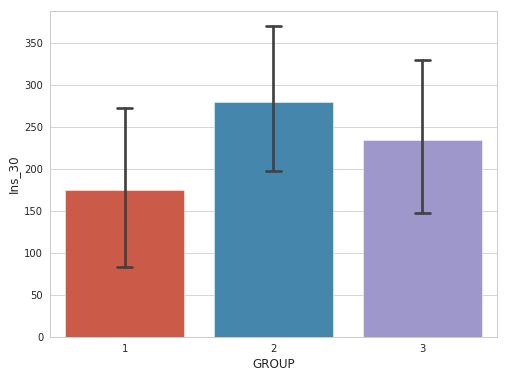

In [0]:
ax = sns.barplot(x='GROUP', y='Ins_30', data=patients, capsize=.1)

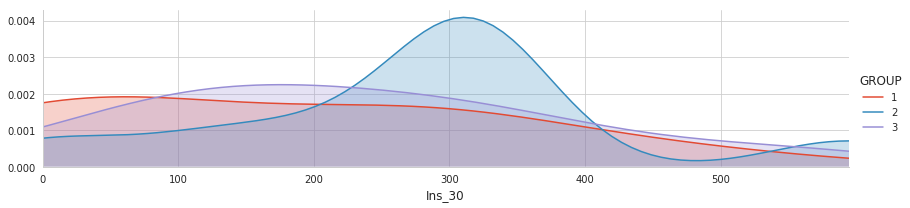

In [0]:
plot_distribution( patients , var = 'Ins_30' , target = 'GROUP')

MM09_30

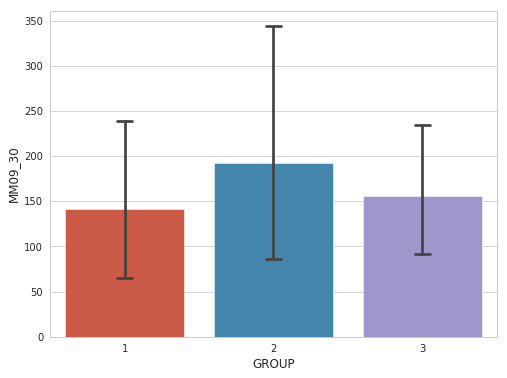

In [0]:
ax = sns.barplot(x='GROUP', y='MM09_30', data=patients, capsize=.1)

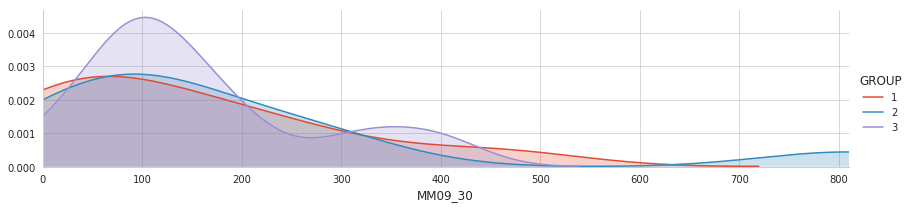

In [0]:
plot_distribution( patients , var = 'MM09_30' , target = 'GROUP')

MM12_30

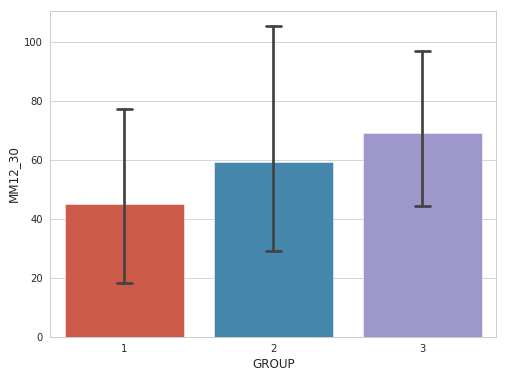

In [0]:
ax = sns.barplot(x='GROUP', y='MM12_30', data=patients, capsize=.1)

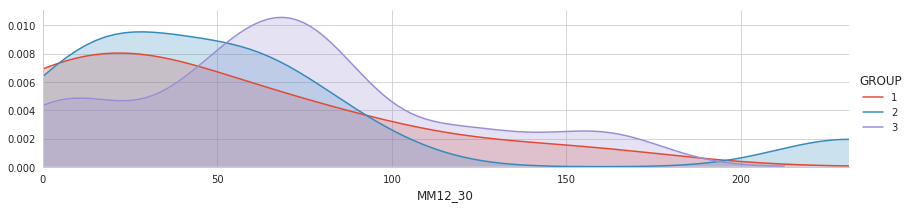

In [0]:
plot_distribution(patients, var = 'MM12_30' , target = 'GROUP')

MM20_30

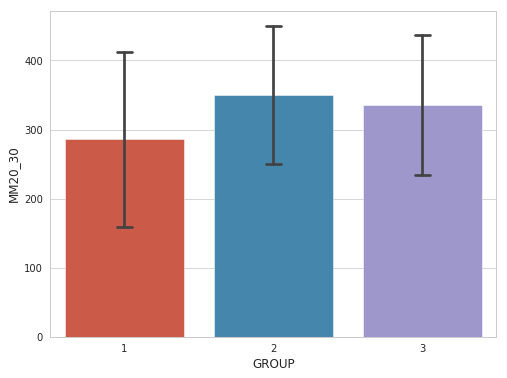

In [0]:
ax = sns.barplot(x='GROUP', y='MM20_30', data=patients, capsize=.1)

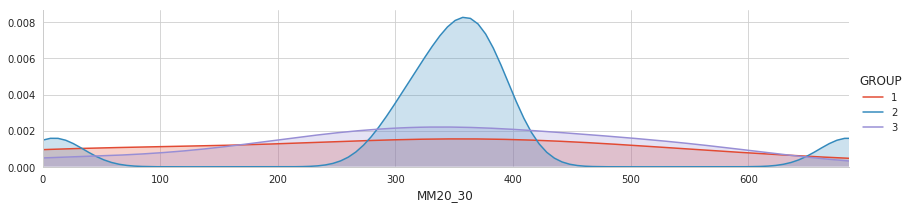

In [0]:
plot_distribution( patients , var = 'MM20_30' , target = 'GROUP')

NAA_30

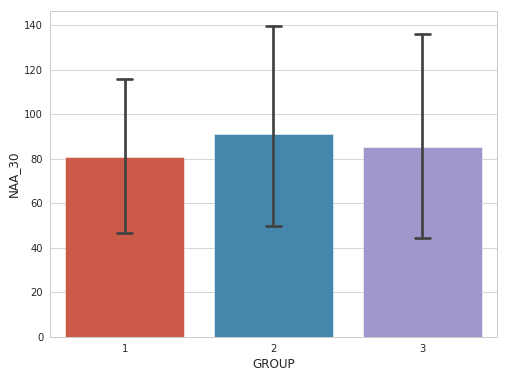

In [0]:
ax = sns.barplot(x='GROUP', y='NAA_30', data=patients, capsize=.1)

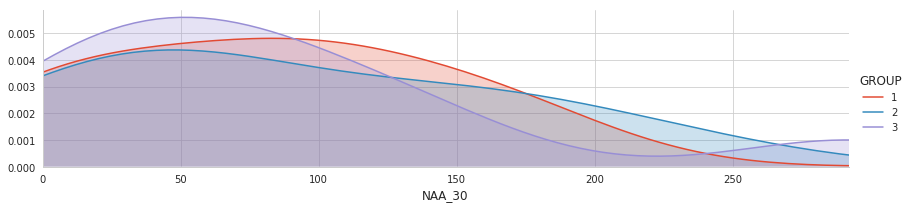

In [0]:
plot_distribution( patients , var = 'NAA_30' , target = 'GROUP')

TNAA_30

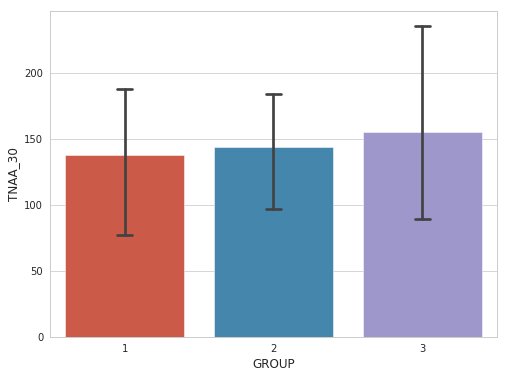

In [0]:
ax = sns.barplot(x='GROUP', y='TNAA_30', data=patients, capsize=.1)

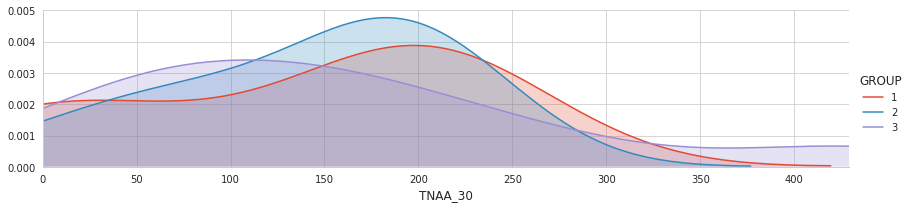

In [0]:
plot_distribution( patients , var = 'TNAA_30' , target = 'GROUP')

TCho_30

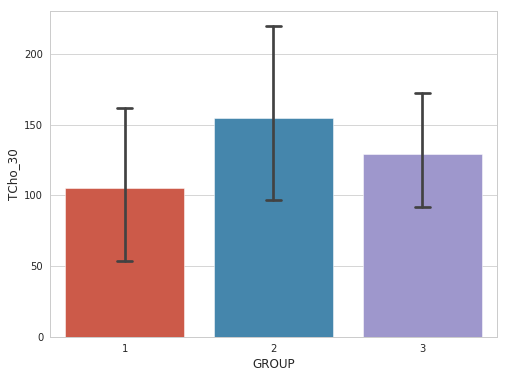

In [0]:
ax = sns.barplot(x='GROUP', y='TCho_30', data=patients, capsize=.1)

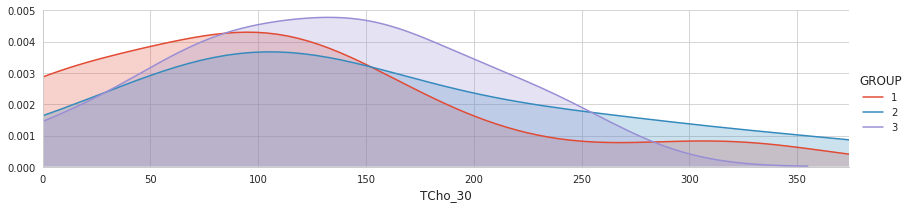

In [0]:
plot_distribution( patients , var = 'TCho_30' , target = 'GROUP')

TCr_30

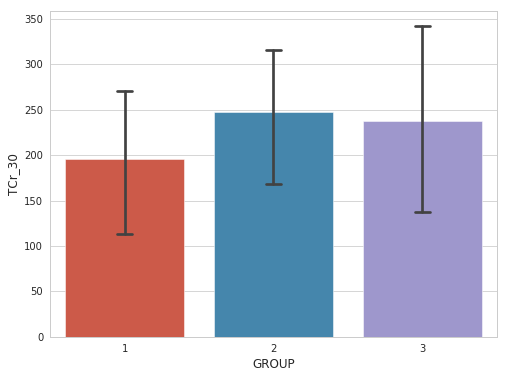

In [0]:
ax = sns.barplot(x='GROUP', y='TCr_30', data=patients, capsize=.1)

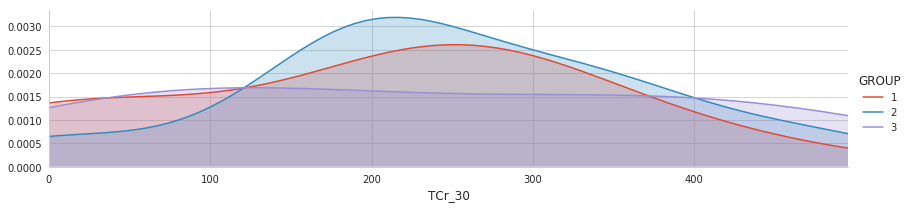

In [0]:
plot_distribution( patients , var = 'TCr_30' , target = 'GROUP')

Glx_30

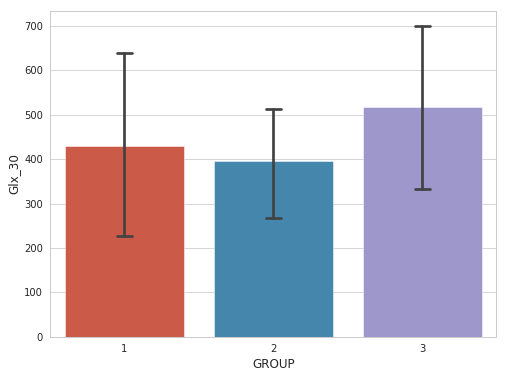

In [0]:
ax = sns.barplot(x='GROUP', y='Glx_30', data=patients, capsize=.1)

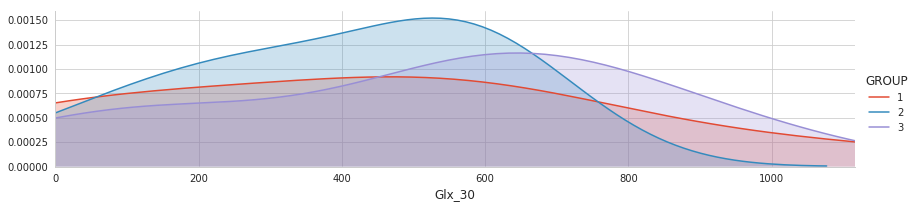

In [0]:
plot_distribution( patients , var = 'Glx_30' , target = 'GROUP')

TLM09_30

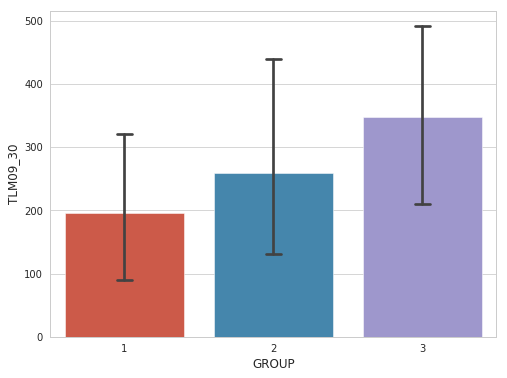

In [0]:
ax = sns.barplot(x='GROUP', y='TLM09_30', data=patients, capsize=.1)

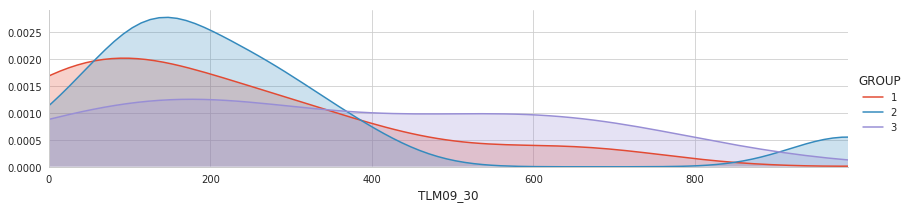

In [0]:
plot_distribution( patients , var = 'TLM09_30' , target = 'GROUP')

TLM13_30

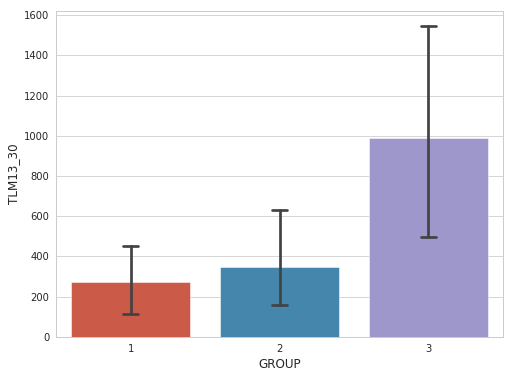

In [0]:
ax = sns.barplot(x='GROUP', y='TLM13_30', data=patients, capsize=.1)

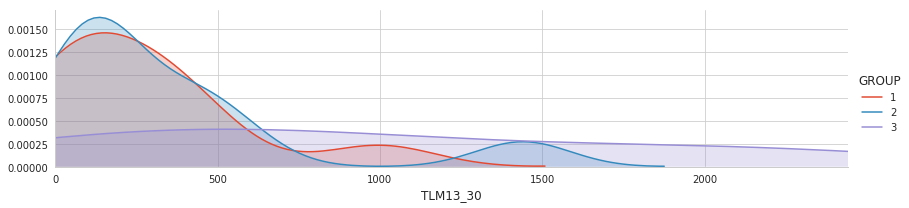

In [0]:
plot_distribution( patients , var = 'TLM13_30' , target = 'GROUP')

TLM20_30

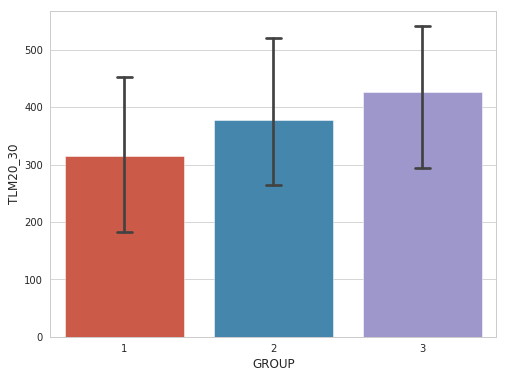

In [0]:
ax = sns.barplot(x='GROUP', y='TLM20_30', data=patients, capsize=.1)

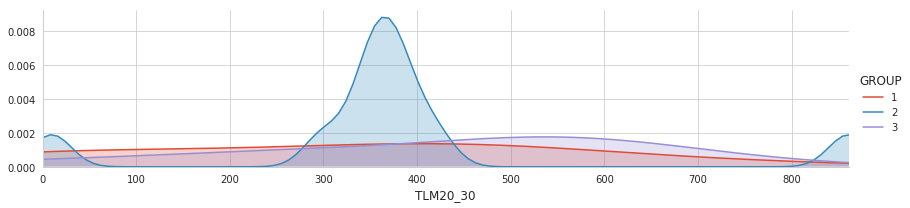

In [0]:
plot_distribution( patients , var = 'TLM20_30' , target = 'GROUP')

Glth_135

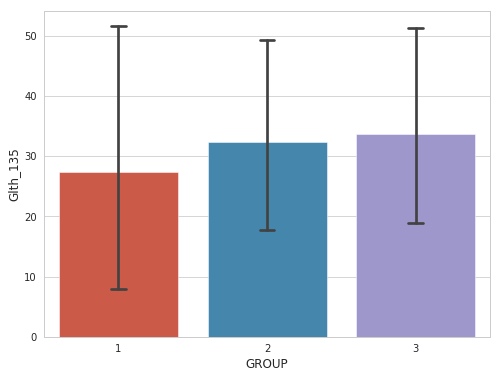

In [0]:
ax = sns.barplot(x='GROUP', y='Glth_135', data=patients, capsize=.1)

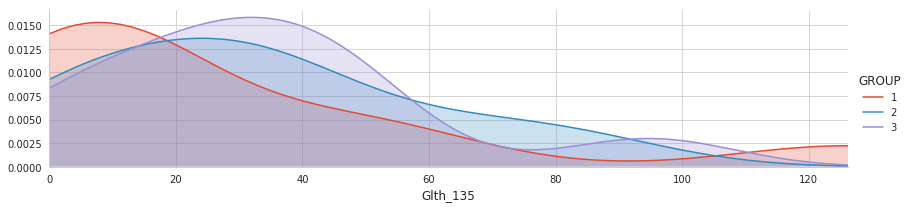

In [0]:
plot_distribution( patients , var = 'Glth_135' , target = 'GROUP')

TCho_135

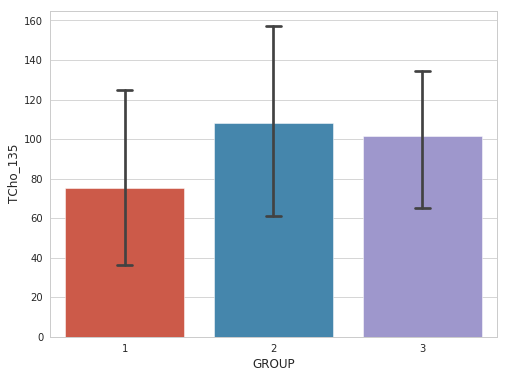

In [0]:
ax = sns.barplot(x='GROUP', y='TCho_135', data=patients, capsize=.1)

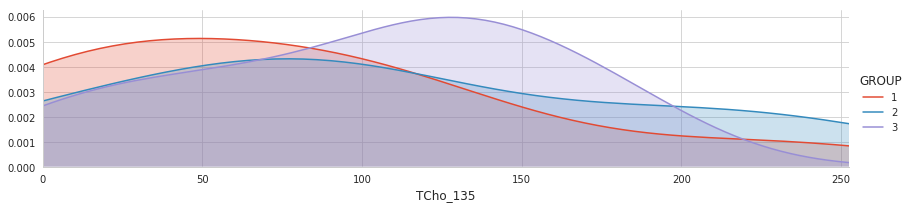

In [0]:
plot_distribution( patients , var = 'TCho_135' , target = 'GROUP')

Glx_135

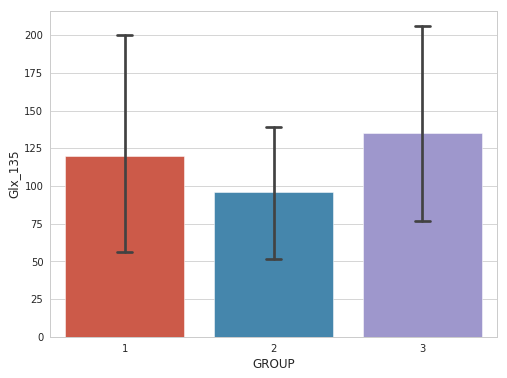

In [0]:
ax = sns.barplot(x='GROUP', y='Glx_135', data=patients, capsize=.1)

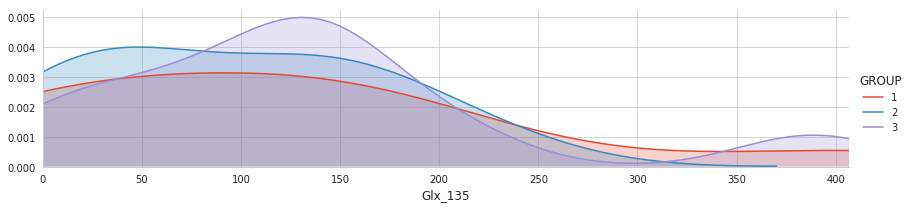

In [0]:
plot_distribution( patients , var = 'Glx_135' , target = 'GROUP')

# 2. Data Preparation

In [0]:
Patients_X = patients.iloc[:,1:-1]
Patients_Y = patients.GROUP

train_X , valid_X , train_y , valid_y = train_test_split( Patients_X , Patients_Y , train_size = .7 )

# 3. Modelowanie

## 3.1 Sprawdzenie różnych modeli treningowych

### 3.1.1 Drzewo decyzyjne

In [0]:
dt_model = DecisionTreeClassifier()
dt_model.fit( train_X , train_y )

print ('Training Accuracy ', dt_model.score( train_X , train_y ) , 'Validation Accuracy ', dt_model.score( valid_X , valid_y ))

Training Accuracy  1.0 Validation Accuracy  0.3333333333333333


### 3.1.2 Las losowy

In [0]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit( train_X , train_y )

print ('Training Accuracy ', rf_model.score( train_X , train_y ) , 'Validation Accuracy ', rf_model.score( valid_X , valid_y ))

Training Accuracy  1.0 Validation Accuracy  0.1111111111111111


### 3.1.3 Gradient Boosting

In [0]:
gb_model = GradientBoostingClassifier()
gb_model.fit( train_X , train_y )

print ('Training Accuracy ', gb_model.score( train_X , train_y ) , 'Validation Accuracy ', gb_model.score( valid_X , valid_y ))

Training Accuracy  1.0 Validation Accuracy  0.1111111111111111


# 5. AUC-ROC

In [0]:
probs = gb_model.predict_proba(valid_X)
n_classes = Patients_Y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(valid_y[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

IndexError: ignored

In [0]:
# Predict probabilities of validation data
probs = gb_model.predict_proba(valid_X)
print(probs)

# # Keep probabilities of positive class only
# probs = probs[:, 1]

# # Compute AUC Score
# auc = roc_auc_score(valid_y, probs)
# print('AUC: %.2f' % auc)

In [0]:
# Get the ROC Curve.
fpr, tpr, thresholds = roc_curve(valid_y, probs)

# Plot the ROC Curve
plot_roc_curve(fpr, tpr)

# 6. Ważność poszczególnych cech

In [0]:
X_importance = valid_X
explainer = shap.TreeExplainer(gb_model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance)